{download}`Download this notebook <5_quantum_internet.ipynb>`

## Optimizing Quantum Internet
> **Concepts demonstrated below**
> - Cost matrix (edge construction costs are proportional to node separations)
> - Loss landscapes riddled with local minima
> - Batching
> - Noise in `GradNet`

### Problem setup
Here, we optimize the communication capacity of a quantum internet with lossy channels. The geographic placement of quantum computers are sampled randomly, and wiring costs are assumed to be proportional to the distance between nodes. We compute the pairwise distances $D_{ij}$, and optimize the adjacency matrix $A_{ij}$ under the constrained construction budget $b=\frac{1}{2}\sum_{ij}D_{ij}A_{ij}$.

Following the derivations in [1], we define the transmissivity of each edge $e$ as $\eta_e$. We model the edge transmissivities from the edge weights using the mapping $\eta_{ij} = \tanh{A_{ij}}$. The composite transmissivity along some path $P=\{e_1, e_2, ..., e_K\}$ is given by the bottleneck transmissivity along the chain $\eta_P = \min_{e\in P}\eta_e$ (see [1] for details). And the capacity of this chain is given by

$$
\mathcal C_P = -\log_2(1-\eta_P).
$$

The communication capacity between two nodes $(i,j)$ in a network is the capacity of the best path $P_{ij}$ connecting them

$$
\mathcal C_{ij} = \max_{P_{ij}} C_P = -\log_2(1-\max_{P_{ij}}\min_{e\in P}\eta_e).
$$

The mean network capacity, and the target of our optimization, is then given by 

$$
\mathcal C = \frac{1}{n(n-1)} \sum_{i\ne j} {\mathcal C_{ij}} = -\frac{1}{n(n-1)} \sum_{i\ne j}\log_2(1-\max_{P_{ij}}\min_{e\in P}\eta_e).
$$

[1] Pirandola, S., 2019. End-to-end capacities of a quantum communication network. *Communications Physics*, 2(1), p.51.


### Functions for computing channel capacities and the loss function 

In [7]:
import torch
import matplotlib.pyplot as plt
from gradnet import GradNet, fit
from gradnet.utils import positions_to_distance_matrix, plot_graph, random_seed
import networkx as nx
import numpy as np


def mean_pairwise_min_cut(A: torch.Tensor) -> torch.Tensor:
    """
    Compute the mean value of pairwise minimum s–t cuts on an undirected
    weighted graph with adjacency/capacity matrix A (nonnegative, symmetric).
    """
    assert A.ndim == 2 and A.shape[0] == A.shape[1], "A must be square"
    n = A.shape[0]
    device = A.device
    dtype = A.dtype

    # Build NetworkX graph using *detached* capacities, so no grad flows here.
    A_cpu = A.detach().cpu().numpy()
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i + 1, n):
            w = float(A_cpu[i, j])
            if w > 0.0:  # treat zero as 'no edge'
                G.add_edge(i, j, capacity=w)

    # Accumulate total cut value as a Torch scalar on the original device.
    total = A.new_tensor(0.0)

    # Loop over unordered pairs (s, t)
    for s in range(n):
        for t in range(s + 1, n):
            # Min s–t cut: we only use the partition, *not* the numeric value
            cut_value, partition = nx.minimum_cut(G, s, t, capacity="capacity")
            S, T = partition  # S and T = V \ S

            # Build a boolean mask for nodes in S on the Torch device
            s_mask = torch.zeros(n, dtype=torch.bool, device=device)
            s_indices = torch.tensor(list(S), dtype=torch.long, device=device)
            s_mask[s_indices] = True

            # Edges crossing the cut: exactly one endpoint in S
            cross = s_mask.unsqueeze(0) ^ s_mask.unsqueeze(1)  # XOR
            # For an undirected graph with symmetric A, count each edge once:
            cross = torch.triu(cross, diagonal=1)

            # Cut value expressed as linear combination of A entries
            cut_val_torch = (A * cross.to(dtype)).sum()
            total = total + cut_val_torch

    num_pairs = n * (n - 1) // 2
    mean_cut = total / num_pairs
    return mean_cut


def multi_path_routing_capacity(A):
    eta = torch.tanh(A)
    c = - torch.log(1-eta)/torch.log(torch.tensor(2.0))
    return mean_pairwise_min_cut(c)


def average_channel_capacity(A):
    ''' computes the mean channel capacity in the given weighted network based on reference [1] '''
    eta = torch.tanh(A).clone()             # edge transmissivities
    n = eta.size(0)
    for k in range(n):                    # widest-path Floyd–Warshall (max-min)
        via_k = torch.minimum(eta[:, k].unsqueeze(1), eta[k, :].unsqueeze(0))
        eta = torch.maximum(eta, via_k)
    eta = eta.clamp(max=1-1e-12)            # path transmissivities
    C = -torch.log2(1 - eta)              # path capacities
    mask = ~torch.eye(n, dtype=bool, device=A.device)
    return C[mask].mean()


def loss_fn_constructor(batch_size, noise_amplitude):
    def loss_fn(gn):
        capacities = torch.zeros(batch_size)
        for i in range(batch_size):
            A = gn(noise_amplitude=noise_amplitude)
            capacities[i] = average_channel_capacity(A)
            # capacities[i] = multi_path_routing_capacity(A)
        return -capacities.mean(), {'capacity': average_channel_capacity(gn()).item()}
    return loss_fn

### Optimization

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


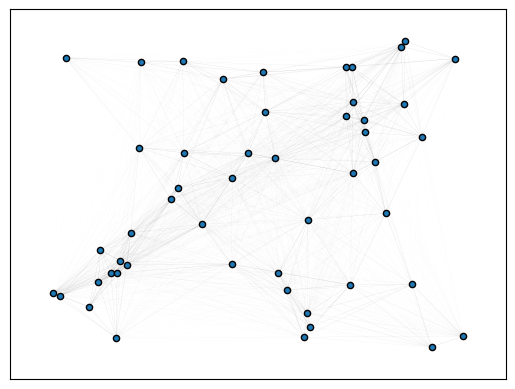

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


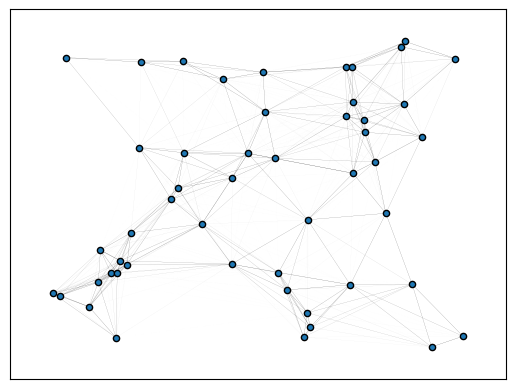

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


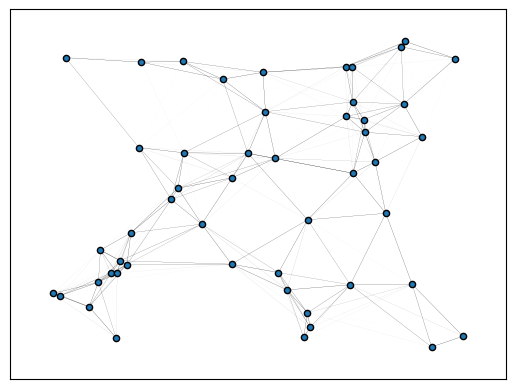

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


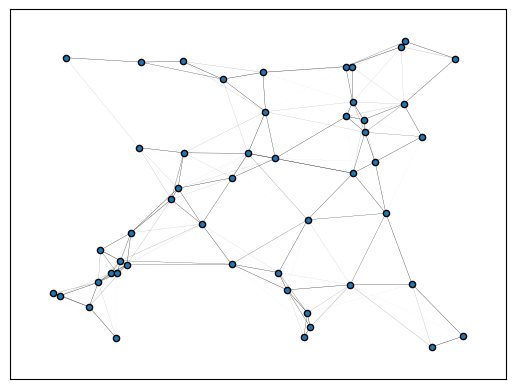

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/200 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=200` reached.


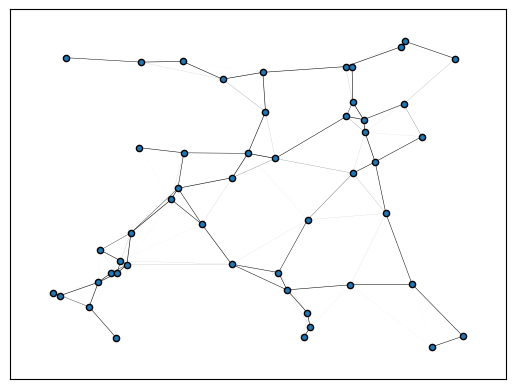

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/1000 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=1000` reached.


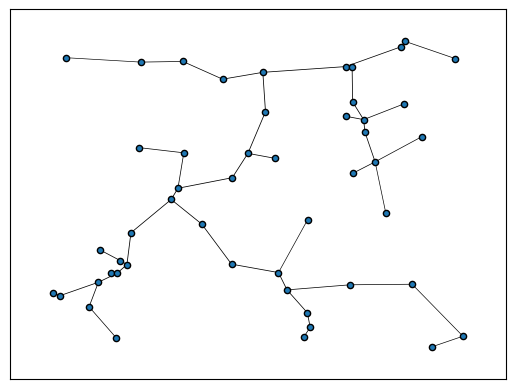

In [8]:
N = 50
L = 10.0
budget_per_node = 1

seed = 0
random_seed(seed)

positions = torch.rand(N, 2) * L  # random coordinates in an LxL square
cost_matrix = positions_to_distance_matrix(positions)  # all-to-all distances

pos_dict = {idx: pos.tolist() for idx, pos in enumerate(positions)}
draw_kwargs = {
    "pos": pos_dict,
    "with_labels": False,
    "node_size": 20
}

updates = [100, 100, 100, 100, 200, 1000]
lrs = [0.005]*7
batch_sizes = [100]*6 + [1]
noises = np.linspace(1, 0, 7)

gn = GradNet(
    num_nodes=N,
    budget=budget_per_node * N,
    cost_matrix=cost_matrix,
    rand_init_weights=0
)

for update, lr, batch_size, noise in zip(updates, lrs, batch_sizes, noises):
    loss_fn = loss_fn_constructor(batch_size=batch_size, noise_amplitude=noise)
    fit(
        gn=gn,
        loss_fn=loss_fn,
        num_updates=update,
        optim_kwargs={"lr": lr},
        enable_checkpointing=False,
        logger=True,
        log_dir=f'lightning_logs/updates-{update}_lr-{lr}_batch{batch_size}_noise{noise}',
        accelerator="cpu",
        verbose=True,
    )
    plot_graph(gn, layout="networkx", draw_kwargs=dict(draw_kwargs))
    plt.pause(0.1)

# plot_graph(gn, layout="networkx", draw_kwargs=dict(draw_kwargs))